In [1]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import os
import re
from html.parser import HTMLParser
from bs4 import BeautifulSoup
from bs4 import element
from numpy import array
import numpy as np
import pylab as pl

# Histogram

In [2]:
def draw_hist(lenths):
    data = lenths 
    bins = np.linspace(min(data),max(data),20)
    pl.hist(data,bins)
    pl.xlabel('Weights')
    pl.ylabel('Number of occurences')
    pl.title('Frequency distribution of weights')
    pl.show()

# Get IAO mapping dict

In [3]:
def get_IAO_mapping_dict():
    whole_mapping_dict={}
    mapping_file = open('/rdsgpfs/general/user/yh4218/home/data/IAO_mapping.txt','r')
    mapping_lines = mapping_file.readlines()
    for line in mapping_lines:
        clean_line=line.strip('\n').split('\t')
        clean_line[0],clean_line[1] = clean_line[1],clean_line[0]
        if '/' in clean_line[1]:
            clean_line[1] = [element.strip(' ') for element in clean_line[1].split('/')]
        else:
            clean_line[1] = [clean_line[1]]
        single_dict=dict([clean_line])
        whole_mapping_dict.update(single_dict)
    return whole_mapping_dict

# Get file

In [4]:
def get_files(base_dir,file_list):
    files = os.listdir(base_dir)
    for i in files:
        abs_path = os.path.join(base_dir,i)
        if re.match(r'(.*)PMC(.*).html',abs_path) and ('highlighted' not in abs_path):
            file_list.append(abs_path)
        elif os.path.isdir(abs_path)&('ipynb_checkpoints' not in abs_path):
            get_files(abs_path,file_list)
    return file_list
            
def remove_duplicates_files(file_list):
    file_list_without_duplicates=[]
    for file in file_list:
        PMC_number=file.split('/')[-1]
        duplicates_status=False
        for f in file_list_without_duplicates:
            if PMC_number in f:
                duplicates_status=True
        if not duplicates_status:
            file_list_without_duplicates.append(file)
    return file_list_without_duplicates

# Extract h2 headings

In [5]:
def extract_h2_headings(file_name):
    with open(file_name,'r',encoding='UTF-8',errors='ignore') as f:
        text = f.read()
        soup = BeautifulSoup(text, 'html.parser')
        
    heading_text_list=[]
    headings = soup.find_all('h2')
    for number, heading in enumerate(headings):
        heading_text =  heading.get_text()
        
        # [heading starts with "1.",heading starts with "P1"]
        pattern_list=['^(([0-9]+\. *)+)','^(P[0-9]+)','^([0-9]+) ']
        pattern_status=False
        for pattern in pattern_list:
            if re.search(pattern,heading_text):
                pattern_status=True
                heading_text_list.append(heading_text.strip(re.search(pattern,heading_text).group()))
                
        if not pattern_status:
            heading_text_list.append(heading_text)
            
    heading_text_list_tmp=[i.lower().strip('.').strip(' ').strip(':').strip(' ').strip('*').strip(':').replace('\n',' ').strip(' ') for i in heading_text_list]
    heading_text_list = [i for i in heading_text_list_tmp if i != 'share' and i !='formats']
    return heading_text_list

# Build node&edge list

In [6]:
def build_node_edge_list(heading_text_dict_with_filename,show_not_mapped_node):
    node_list=[]
    edge_list=[]
    
    for heading_list in heading_text_dict_with_filename.values():
        for number,heading in enumerate(heading_list):
            if number != 0:
                edge_list.append([heading_list[number-1],heading_list[number]])
                
            node_list.append(heading)
            
    whole_node_dict={'Cannot be mapped':[]}        
    for number,node in enumerate(node_list):       
        if node in whole_mapping_dict.keys():
            for number,element in enumerate(whole_mapping_dict[node]):
                if element in whole_node_dict.keys():
                    whole_node_dict[element].append(node)
                else:
                    whole_node_dict[element]=[node]
        
        else:
            whole_node_dict['Cannot be mapped'].append(node)
            
    # replace node list according to  whole_node_dict
    for number,node in enumerate(node_list):
        for key,node_dict_list in whole_node_dict.items():
            if node in node_dict_list:
                if key == 'Cannot be mapped':
                    node_list[number] = 'Cannot be mapped:\n'+node
                else:
                    node_list[number] =  key+':\n'+str(set(node_dict_list))
    
    # replace edge list according to  whole_node_dict
    for number1,edge in enumerate(edge_list):
        for number2,node in enumerate(edge):
            for key,node_dict_list in whole_node_dict.items():
                if node in node_dict_list:
                    if key == 'Cannot be mapped':
                        edge_list[number1][number2] = 'Cannot be mapped:\n'+node
                    else:
                        edge_list[number1][number2] = key+':\n'+str(set(node_dict_list))
                
    if not show_not_mapped_node:
        edge_list_tmp=[]
        for edge in edge_list:
            if not 'Cannot be mapped' in str(edge):
                edge_list_tmp.append(edge)
        edge_list=edge_list_tmp
        
        node_list_tmp=[]
        for node in node_list:
            if not 'Cannot be mapped' in str(node):
                node_list_tmp.append(node)
        node_list=node_list_tmp
                
    edge_list= [tuple(edge) for edge in edge_list]
                
    return node_list, edge_list

# Calculate edge weight and node portion

In [7]:
def calculate_weight(node_list,edge_list,file_list):
    node_portion = {}
    for node in node_list:
        node_portion.update({node:node_list.count(node)/len(file_list)})

    edge_weight = {}
    for edge in edge_list:
        starting_node=edge[0]
        number_of_edge_starts_with_starting_node = 0
        for edge2 in edge_list:
            if edge2[0] == starting_node:
                number_of_edge_starts_with_starting_node += 1
                edge_weight.update({edge:edge_list.count(edge)/number_of_edge_starts_with_starting_node})
    return node_portion, edge_weight


# Draw

In [8]:
def draw(node_list,edge_list,node_portion, edge_weight):
    try:
        G.clear()
        del pos
    except:
        pass
    plt.rcParams['figure.figsize'] = [60, 60]
    
    G = nx.DiGraph()
    G.add_node(node_list[0])

    #nodes
    G.add_nodes_from(node_list)

    #edges
    G.add_edges_from(edge_list)

    #label for nodes
    labels_nodes={}
    for node in node_list:
        labels_nodes[node]=node
    
    #label for edges
    labels_edges={}
    for key,value in edge_weight.items():
        #labels_edges[key]=str(value[0])+','+str(round(value[1],2))
        labels_edges[key]=str(round(value,2))
    
    #position
    #pos=nx.spring_layout(G,pos=initial_position, fixed=common_nodes)
    pos=graphviz_layout(G, prog='dot')
    #for key,value in pos.items():
    #    pos[key] = (value[0]-300,value[1]-300)

    
    # draw
    # add node one by one because some of them are not mapping
    nx.draw_networkx_nodes(G,pos,alpha=0)
    
    for key,value in labels_nodes.items():
        if 'Cannot be mapped' in key:
            nx.draw_networkx_labels(G,pos,{key:value},font_color='red')
        else:
            nx.draw_networkx_labels(G,pos,{key:value})
    
    # add edges one by one because some of them are overlapping (double directed arrow)
    appeared_list=[]
    for edge,weight in labels_edges.items():
        if (edge[1],edge[0]) in edge_list:
            if edge in appeared_list:
                continue
            else:
                appeared_list.append((edge[1],edge[0]))
                appeared_list.append((edge[0],edge[1]))
                nx.draw_networkx_edges(G,pos,edgelist=[(edge[1],edge[0])],width=0.5,min_source_margin=30,min_target_margin =30,connectionstyle='arc3,rad=0.1',edge_color='r')
                nx.draw_networkx_edge_labels(G,pos,edge_labels={(edge[1],edge[0]):labels_edges[(edge[1],edge[0])]},label_pos=0.65,alpha=1,font_color='r')
                
                nx.draw_networkx_edges(G,pos,edgelist=[(edge[0],edge[1])],width=0.5,min_source_margin=30,min_target_margin =30,connectionstyle='arc3,rad=0.1',edge_color='b')
                nx.draw_networkx_edge_labels(G,pos,edge_labels={(edge[0],edge[1]):labels_edges[(edge[0],edge[1])]},label_pos=0.65,alpha=1,font_color='b')
        else:
            nx.draw_networkx_edges(G,pos,edgelist=[edge],width=0.5,min_source_margin=30,min_target_margin =30)
            nx.draw_networkx_edge_labels(G,pos,edge_labels={edge:weight},label_pos=0.65,alpha=1,clip_on=False)
        
    #nx.draw_networkx_edge_labels(G,pos,edge_labels=labels_edges,label_pos=0.65,alpha=1)

# Main

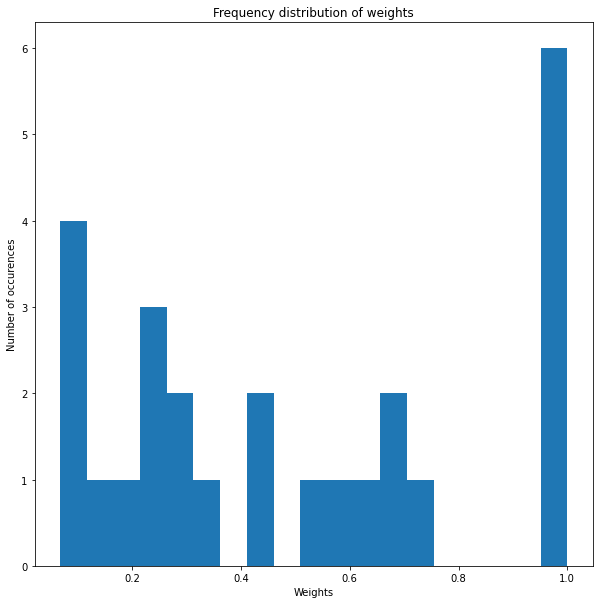

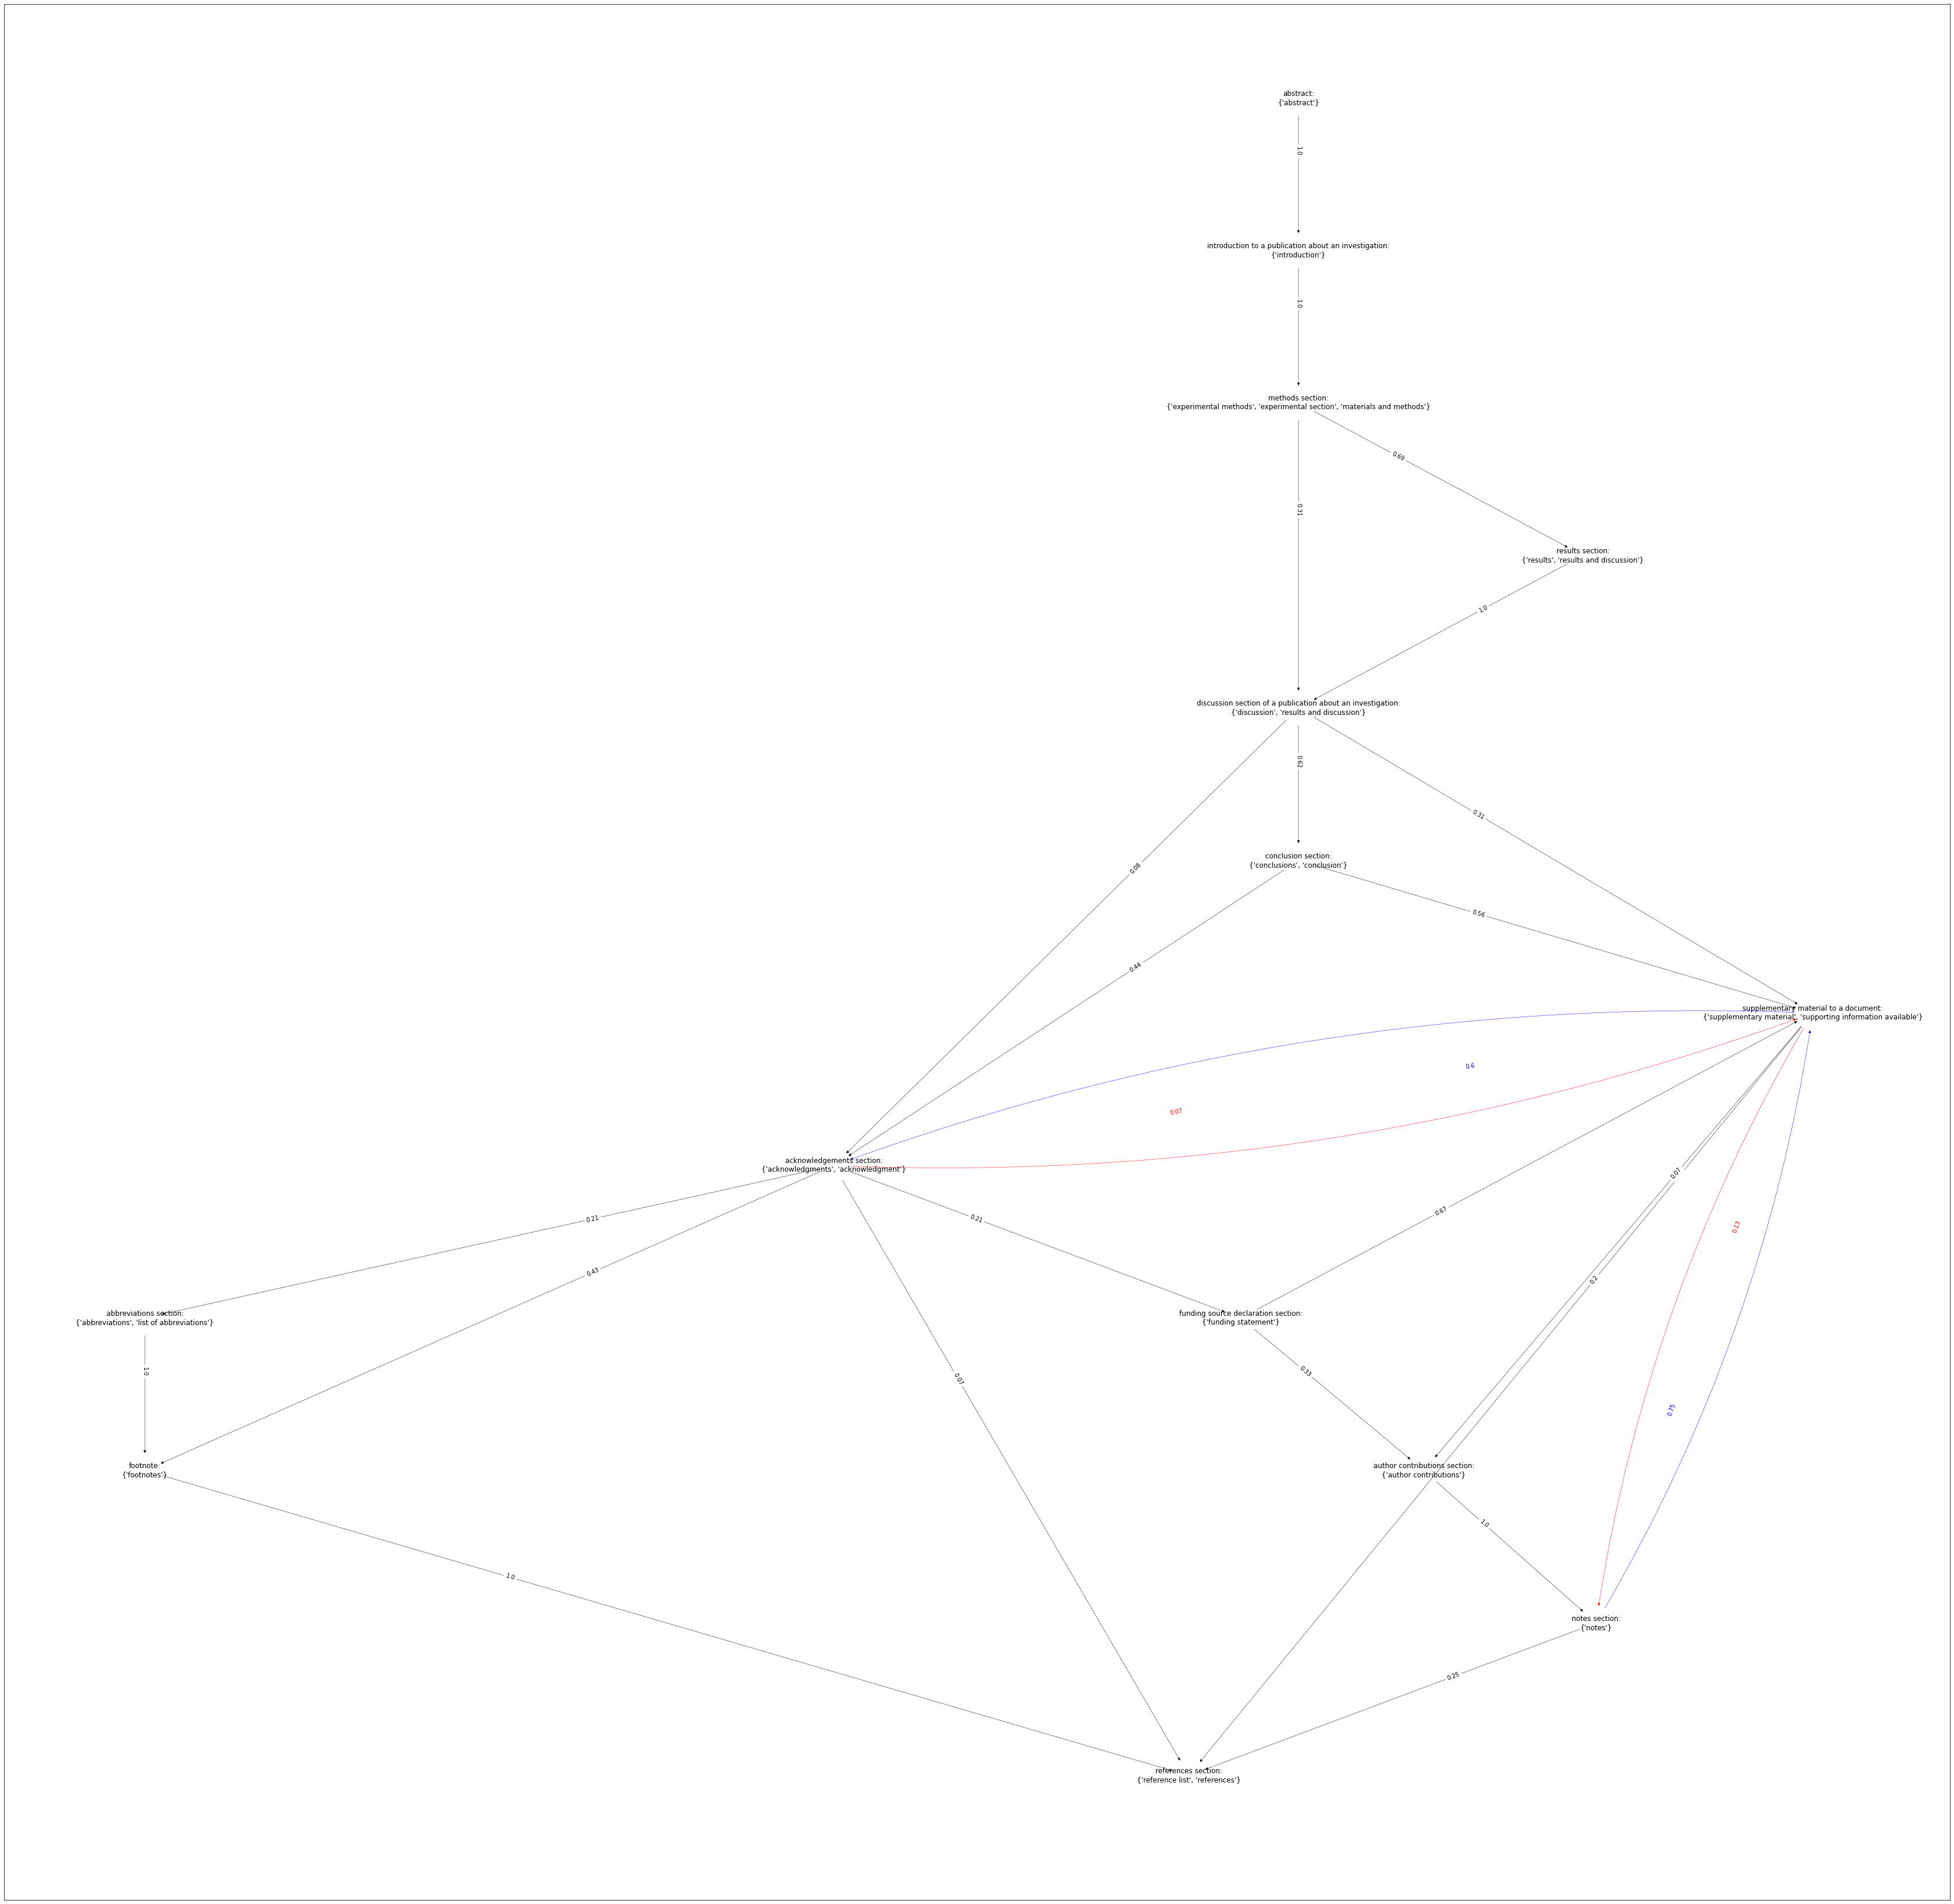

In [9]:
if __name__=='__main__':
    base_dir = '/rdsgpfs/general/user/yh4218/home/data/Journal of Proteome Research (Journal)'
    file_list = []
    file_list = get_files(base_dir,file_list)
    file_list = remove_duplicates_files(file_list)
    
    whole_mapping_dict=get_IAO_mapping_dict() 
    
    heading_text_dict_with_filename={}
    
    for file in file_list:
        PMC_number = file.split('/')[-1].strip('.html')
        heading_list = extract_h2_headings(file)
        heading_text_dict_with_filename.update({PMC_number:heading_list})
    
    show_not_mapped_node = False
    node_list,edge_list = build_node_edge_list(heading_text_dict_with_filename,show_not_mapped_node)
            
    node_portion, edge_weight = calculate_weight(node_list,edge_list,file_list)
    
    # check histogram
    plt.rcParams['figure.figsize'] = [10, 10]
    draw_hist(edge_weight.values())
    
    # draw DAG
    draw(node_list,edge_list,node_portion,edge_weight)


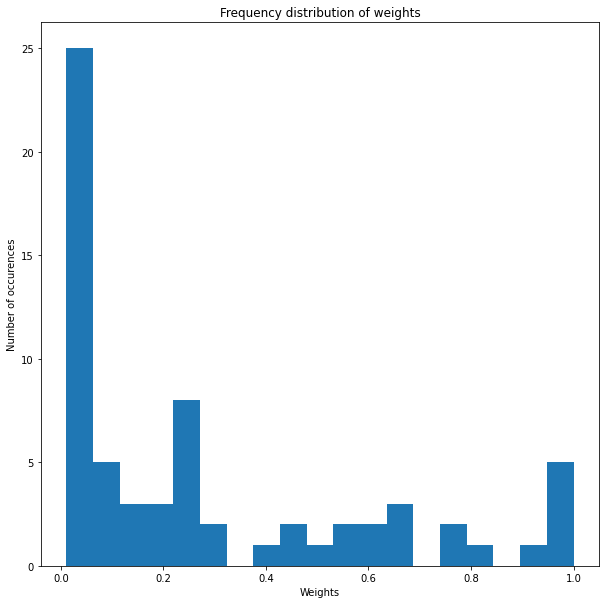

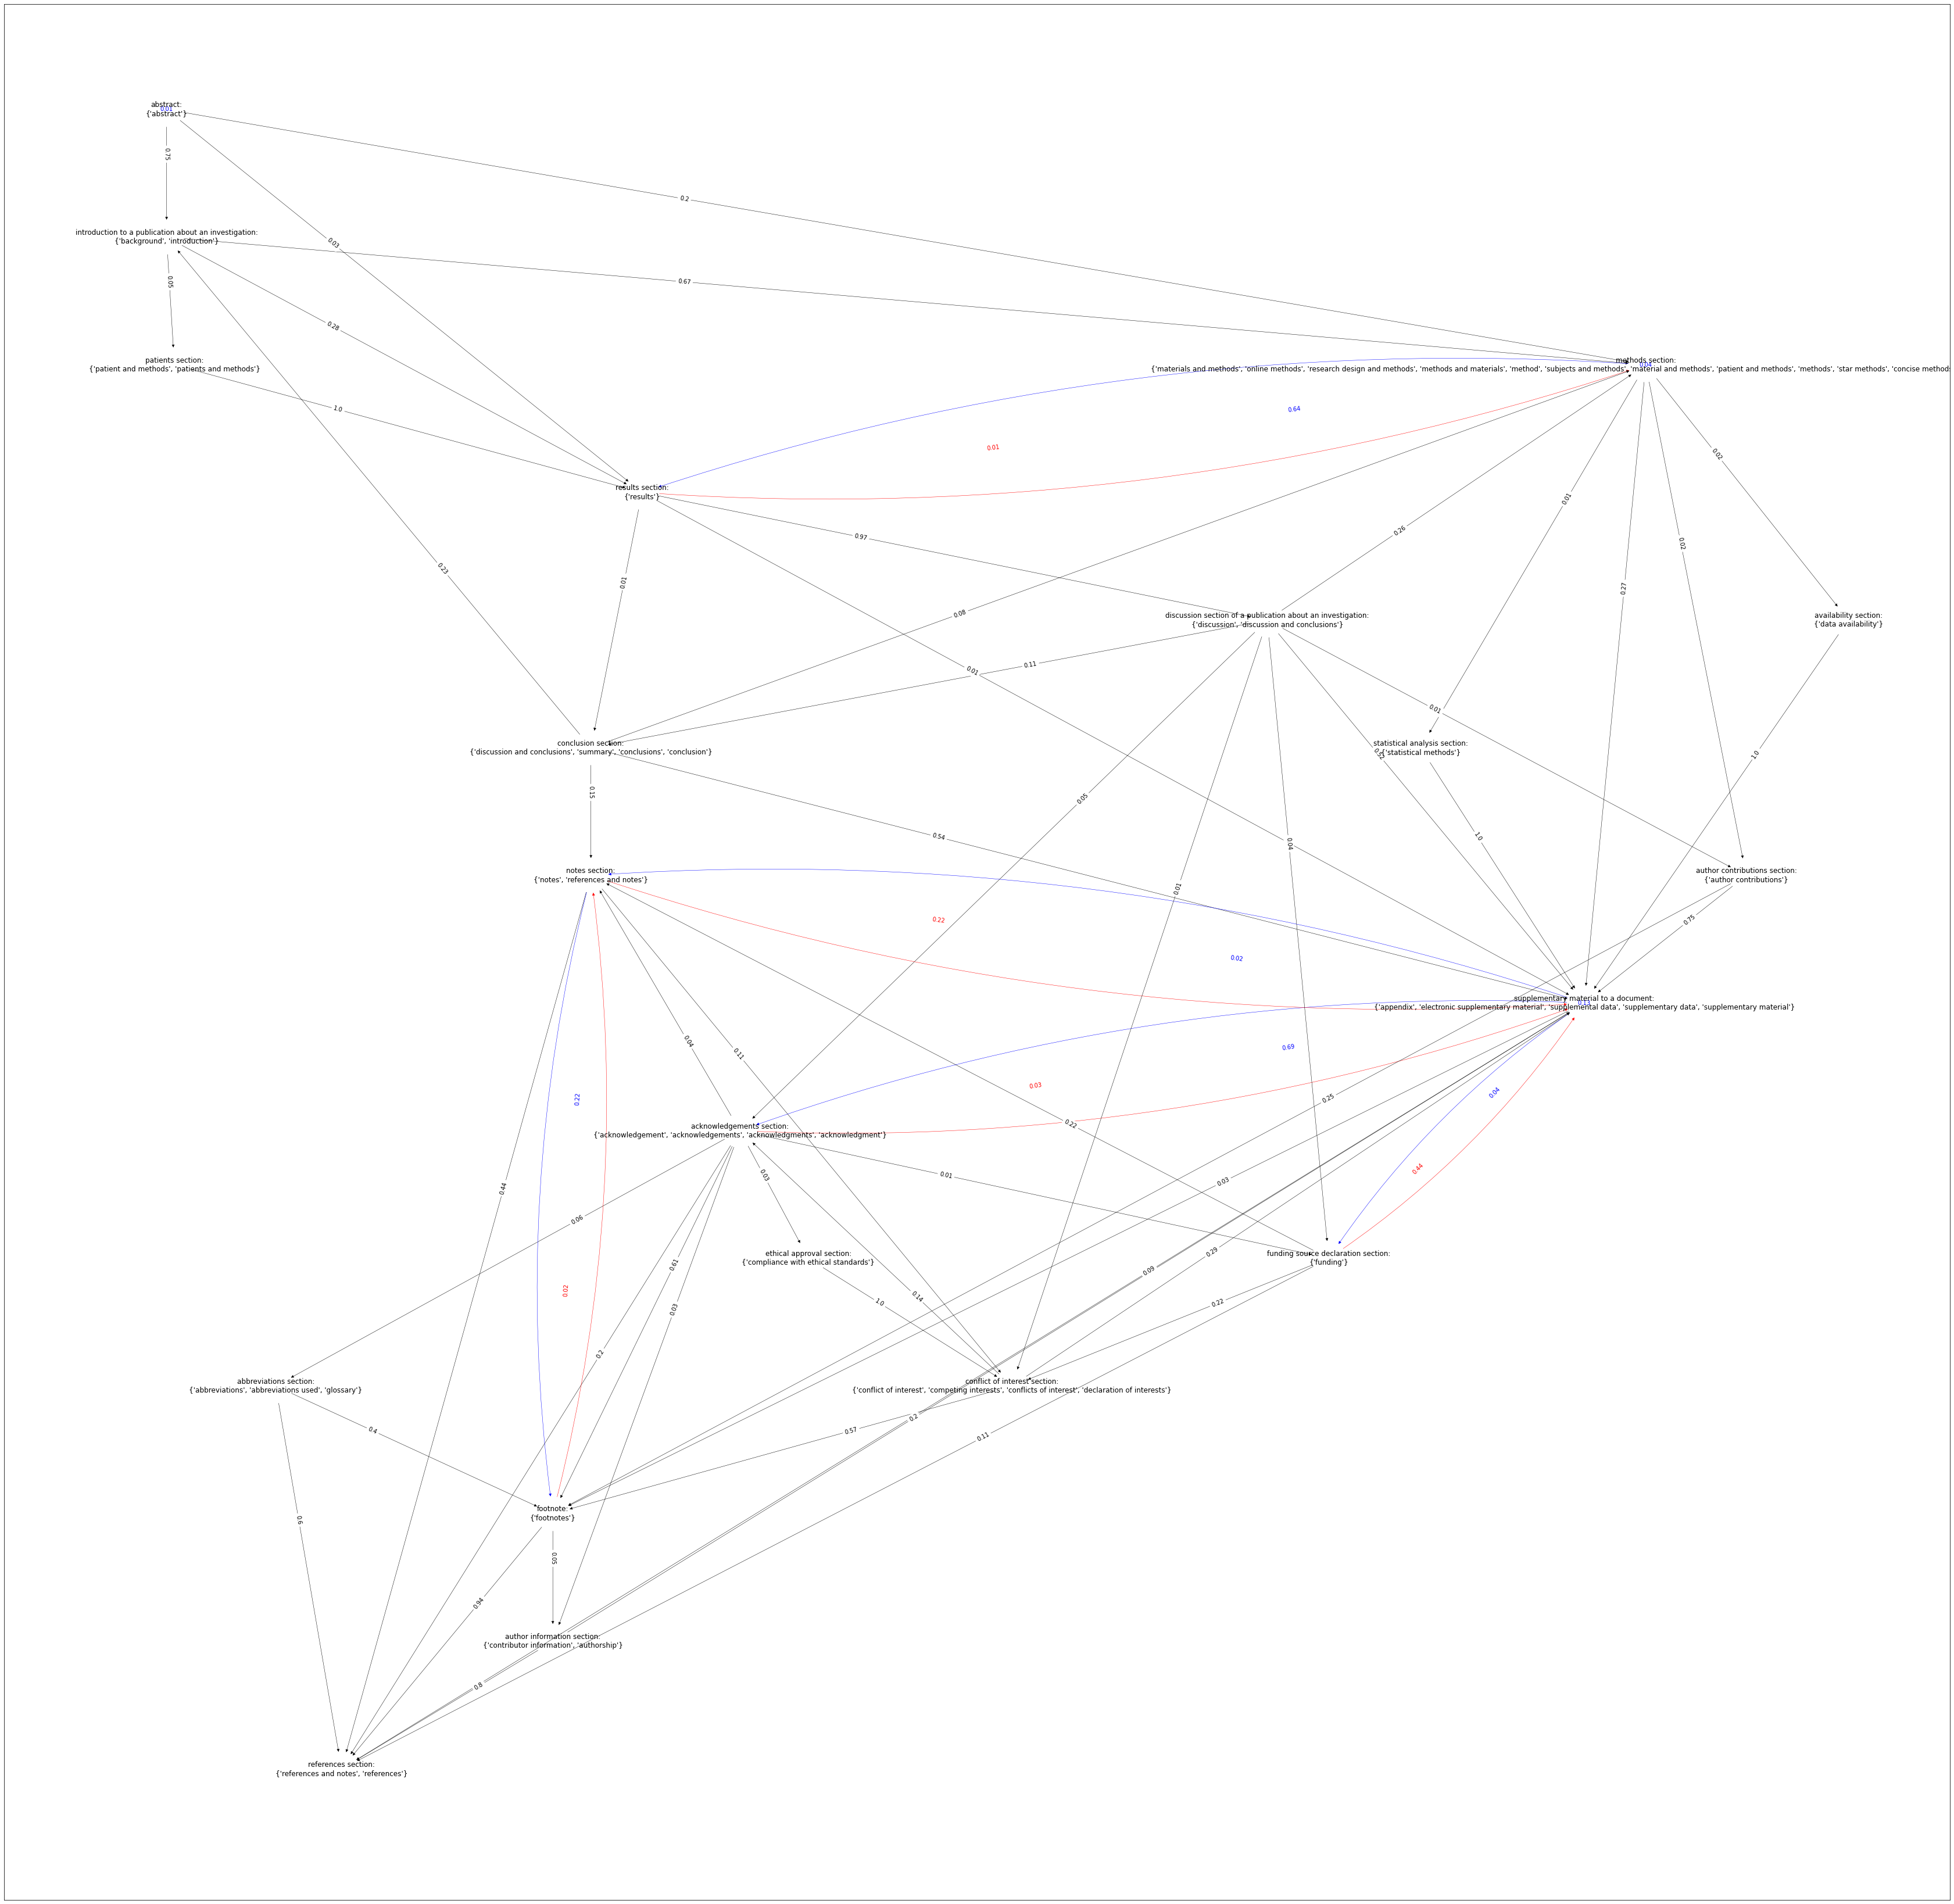

In [10]:
if __name__=='__main__':
    base_dir = '/rdsgpfs/general/user/yh4218/home/data/NLP/NLP-GWAS/1-100'
    file_list = []
    file_list = get_files(base_dir,file_list)
    file_list = remove_duplicates_files(file_list)
    
    whole_mapping_dict=get_IAO_mapping_dict()
    
    heading_text_dict_with_filename={}
    
    for file in file_list:
        PMC_number = file.split('/')[-1].strip('.html')
        heading_list = extract_h2_headings(file)
        heading_text_dict_with_filename.update({PMC_number:heading_list})
    
    show_not_mapped_node = False
    node_list,edge_list = build_node_edge_list(heading_text_dict_with_filename,show_not_mapped_node)
            
    node_portion, edge_weight = calculate_weight(node_list,edge_list,file_list)
    
    # check histogram
    plt.rcParams['figure.figsize'] = [10, 10]
    draw_hist(edge_weight.values())
    
    # draw DAG
    draw(node_list,edge_list,node_portion,edge_weight)

In [11]:
if __name__=='__main__':
    base_dir = '/rdsgpfs/general/user/yh4218/home/data/NLP/NLP-mixed/'
    file_list = []
    file_list = get_files(base_dir,file_list)
    file_list = remove_duplicates_files(file_list)
    
    whole_mapping_dict=get_IAO_mapping_dict()
    
    heading_text_dict_with_filename={}
    
    for file in file_list:
        PMC_number = file.split('/')[-1].strip('.html')
        heading_list = extract_h2_headings(file)
        heading_text_dict_with_filename.update({PMC_number:heading_list})
        
    node_list,edge_list = build_node_edge_list(heading_text_dict_with_filename)
    node_portion, edge_weight = calculate_weight(node_list,edge_list,file_list)
    
    draw(node_list,edge_list,node_portion,edge_weight)


TypeError: build_node_edge_list() missing 1 required positional argument: 'show_not_mapped_node'

In [ ]:
if __name__=='__main__':
    base_dir = '/rdsgpfs/general/user/yh4218/home/data/NLP'
    file_list = []
    file_list = get_files(base_dir,file_list)
    file_list = remove_duplicates_files(file_list)
    
    whole_mapping_dict=get_IAO_mapping_dict()
    
    heading_text_dict_with_filename={}
    
    for file in file_list:
        PMC_number = file.split('/')[-1].strip('.html')
        heading_list = extract_h2_headings(file)
        heading_text_dict_with_filename.update({PMC_number:heading_list})
        
    node_list,edge_list = build_node_edge_list(heading_text_dict_with_filename)
    node_portion, edge_weight = calculate_weight(node_list,edge_list,file_list)
    
    draw(node_list,edge_list,node_portion,edge_weight)